# Introduction

Выделяют два подхода к построению рекомендательных систем. Это collaborative filtering и content-based. Для первого подхода я продемонстрирую реализацию алгоритмов основанных на KNN и Matrix Factorization. Для второго подхода будет использована технология векторизации содержимого TF-IDF. Ранжирование буду производить на основе так называемого косинусного расстояния. 

Качество всех алгоритмов я оценю на "полных" данных, которые выделю из имеющихся. Также будет попытка сравнения этих алгоритмов.

# Data analysis

In [1]:
#required modules
import pandas as pd
import numpy as np

# reading data
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

Ниже представлены данные:

In [2]:
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [3]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [4]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [5]:
tags.movieId

0        60756
1        60756
2        60756
3        89774
4        89774
         ...  
3678      7382
3679      7936
3680      3265
3681      3265
3682    168248
Name: movieId, Length: 3683, dtype: int64

In [6]:
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


При желании можно использовать информацию из links, чтобы парсить контент со странички фильма и использовать это в content-based подходе. В силу ограниченности времени, этот идея реализована не будет. От timestamp'ов я тоже избавлюсь:

In [7]:
ratings.drop(columns='timestamp', inplace = True)
tags.drop(columns='timestamp', inplace = True)

# Collaborative filtering

## Comaprison idea

Оба заявленных мной подхода (KNN и Matrix Factorization) используют матричное предстваление данных, "дырки" в которых они и пытаются заполнить ("дырки" -- это как раз те самые рекомендации, т.е. в нашем случае прогнозируемые оценки для фильмов, которые юзер не смотрел). 

Для тестирования обоих алгоритмов, нужна полностью заполенная матрица -- т.е. матрица, где каждый фильм посмотрел каждый юзер. Далее я искуственно наделаю в ней пропусков и посмотрю, как оба алгоритма будут справляться с их заполнениями. В качестве метрики качества будем использовать rmse. Для работы на этом этапе пригодится только датасет ratings.

Откуда я возьму матрицу с полными данными? Ниоткуда. Из имеющейся матрицы я выкину набиолее неактивных пользователей, которые поставили меньше всего оценок. Также я избавлюсь от самых непросмотренных фильмов. Как только меня устроит результат, отсутствующие значения я заполню средним по всей матрице.

In [8]:
# matrix (datframe that looks like matrix) creation
m_true = ratings.pivot(index='userId',columns='movieId', values='rating')

In [9]:
# demonstration
m_true.loc[:10,:10]

movieId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,3.0
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Как факт -- nan'ов очень много. Вот доля дырок во всей таблице:

In [10]:
# propotion of missing values
print('proportion of missing values', m_true.isna().sum().sum() / (m_true.shape[0]*m_true.shape[1]))

proportion of missing values 0.9830003169443864


98% дырок.

Сейчас я отсортирую по убыванию полные данные. Чем правее колонка (фильм), тем больше пользователей его не видело, чем ниже ряд (пользователь), тем меньше фильмов он оценил. Соритировка будет производится посредством введения колонки с этим признаком. Таким подходом я вычлению 50 самых активных пользователей и 50 самых просматриваемых фильмов стреди них.

In [11]:
# cutting by users
m_true['missing'] = m_true.T.isna().sum()
m_true = m_true.sort_values(by=['missing'])[:50].T
m_true.drop('missing',axis = 0, inplace = True)

# cutting by movies
m_true['missing'] = m_true.T.isna().sum()
m_true = m_true.sort_values(by=['missing'])[:50].T
m_true.drop('missing',axis = 0, inplace = True) 

In [12]:
m_true.iloc[:10,:10]

movieId,2571,260,356,1196,480,1210,1036,1198,780,296
userId,,,,,,,,,,
414,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0
599,5.0,5.0,3.5,5.0,4.0,5.0,4.0,3.5,3.5,5.0
474,4.5,4.0,3.0,5.0,4.5,4.0,3.0,4.0,4.0,4.0
448,2.0,5.0,3.0,5.0,3.0,5.0,5.0,5.0,3.0,5.0
274,4.0,3.0,4.5,4.5,3.5,4.0,4.0,4.0,3.5,5.0
610,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,3.5,5.0
68,4.5,5.0,3.5,5.0,3.5,5.0,3.0,5.0,4.0,2.0
380,4.5,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0
606,5.0,4.5,4.0,4.5,2.5,4.5,NaN,3.5,2.5,5.0


Видно, что желаемого потихонечку добиваемся. Nan'ы уходят. Датасет получился не слишком большой (50 x 50), но это уже хоть что-нибудь. Ниже я покажу какая часть данных тут отсутствует:

In [13]:
#shape
print('shape', m_true.shape)

shape (50, 50)


In [14]:
# missing values
print('missing values', m_true.isna().sum().sum())

missing values 451


In [15]:
#propotion of missing values
print('proportion of missing values', m_true.isna().sum().sum() / (m_true.shape[0]*m_true.shape[1]))

proportion of missing values 0.1804


Короче, отсутствует всего 18% данных, что вполне терпимо. Их я заполню средним значением по своей колонке (нановская ячейка получит среднее по своей колонке) и округлю.

In [16]:
# filling missing values with its' column mean
m_true.fillna(m_true.mean(), inplace = True)

Получаем это:

In [17]:
m_true.iloc[:10,:10]

movieId,2571,260,356,1196,480,1210,1036,1198,780,296
userId,,,,,,,,,,
414,5.0,5.0,5.0,5.0,4.0,5.0,5.000000,5.0,4.0,5.0
599,5.0,5.0,3.5,5.0,4.0,5.0,4.000000,3.5,3.5,5.0
474,4.5,4.0,3.0,5.0,4.5,4.0,3.000000,4.0,4.0,4.0
448,2.0,5.0,3.0,5.0,3.0,5.0,5.000000,5.0,3.0,5.0
274,4.0,3.0,4.5,4.5,3.5,4.0,4.000000,4.0,3.5,5.0
610,5.0,5.0,3.0,5.0,5.0,5.0,5.000000,5.0,3.5,5.0
68,4.5,5.0,3.5,5.0,3.5,5.0,3.000000,5.0,4.0,2.0
380,4.5,5.0,5.0,5.0,5.0,5.0,5.000000,5.0,4.0,5.0
606,5.0,4.5,4.0,4.5,2.5,4.5,3.761364,3.5,2.5,5.0


Последний полученный датафрейм -- это как бы наши "полные данные", в которых мне следует наделать дырок и сравнить качество работы алгоритмов. Требуется сгенерировать этот самый "дырочный" датафрейм. Сколько данных выбрасывать -- вопрос сложный. Очевидно, что крайности здесь плохи. Я наобум возьму долю в 20 процентов. То есть пятая часть всех данных будет удалена и я буду их восстанавливать посредством KNN и Matrix Factorization. А далее сравнивать результаты.

In [18]:
# making nans
m_naned = m_true.copy()
for col in m_naned.columns:
    m_naned.loc[m_naned.sample(frac=0.2).index, col] = np.nan

Обещанный дырочный датафрейм:

In [19]:
m_naned.iloc[:10,:10]

movieId,2571,260,356,1196,480,1210,1036,1198,780,296
userId,,,,,,,,,,
414,NaN,5.0,5.0,NaN,4.0,5.0,5.0,5.0,NaN,5.0
599,5.0,5.0,3.5,5.0,NaN,5.0,4.0,3.5,3.5,NaN
474,4.5,4.0,3.0,5.0,4.5,4.0,NaN,4.0,4.0,4.0
448,2.0,5.0,3.0,5.0,3.0,5.0,5.0,5.0,3.0,5.0
274,4.0,NaN,NaN,4.5,NaN,4.0,4.0,4.0,3.5,5.0
610,NaN,5.0,3.0,5.0,5.0,5.0,5.0,5.0,3.5,5.0
68,4.5,5.0,NaN,NaN,NaN,5.0,3.0,5.0,4.0,2.0
380,4.5,NaN,5.0,5.0,5.0,NaN,5.0,5.0,4.0,NaN
606,5.0,4.5,NaN,4.5,2.5,4.5,NaN,NaN,2.5,5.0


In [20]:
#propotion of missing values
print('proportion of missing values', m_naned.isna().sum().sum() / (m_naned.shape[0]*m_naned.shape[1]))

proportion of missing values 0.2


## Comparison

### KNN

Ниже будет написана функция, которая прогоняет нановский датасет через алгоритм KNN. Прогоняет она его несколько раз, каждый раз используя различное значение соседей. На каждой иттерации считается rmse ошибка. Ошибка в зависимости от числа соседей плотается.

In [21]:
from typing import List
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

    
def KNN_res(m_naned: pd.DataFrame, m_true: pd.DataFrame, n: List[int]) -> int:
    
    '''
    m_naned - датафрейм с дырками, который KNN будет заполнять
    m_true - исходный правильный датафрейм, от которого будет считаться отклонение в терминах rmse
    n - список значений для параметра "число соседей"
    
    Функция для каждого значения из n пытается восстановить KNN'ом m_naned до m_true и считает ошибку,
    которая у нее вышла. Далее по массиву полученных ошибок и массиву n плотает результат.
    Также она возвращает оптимальное количество сосейдей в методе KNN
    '''
    
    # array of errors
    err = []
    
    # cycle for n:
    for k in n:
        
        # knn by itself
        imputer = KNNImputer(n_neighbors=k)
        
        # filling nans
        res = imputer.fit_transform(m_naned)
        
        # creating dataframe of previos result
        m_restored = pd.DataFrame(res, index = m_true.index, columns = m_true.columns)
        
        # counting rmse
        err += [np.sqrt(mse(m_restored, m_true))]
        
    # plotting
    plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(n, err, label = 'rmse', linewidth = 2)
    plt.grid()
    plt.xlabel('nearest neighbors')
    plt.ylabel('rmse for KNN')
    plt.legend()
    plt.show()
    
    # return optimal number of neighbours
    return err.index(min(err)) + 1

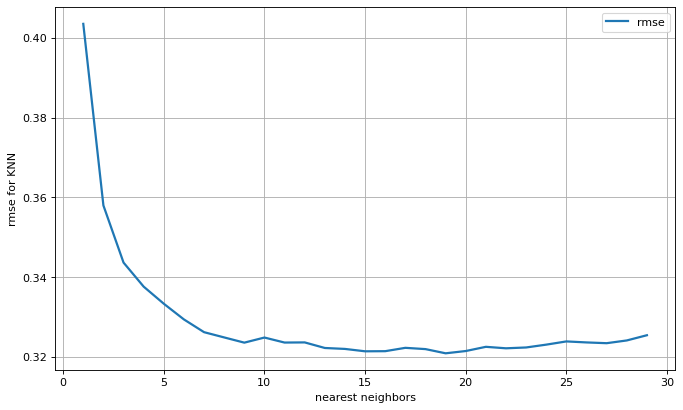

In [22]:
nn = KNN_res(m_naned, m_true, np.arange(1,30))

Видим, где находится оптимум. Вывожу rmse для оптимума.

In [23]:
# repeating pipeline

res = KNNImputer(n_neighbors = nn).fit_transform(m_naned)
m_restored = pd.DataFrame(res, index = m_true.index, columns = m_true.columns)
print(f'with {nn} nearest neighbors rmse = ', np.sqrt(mse(m_restored, m_true)))

with 19 nearest neighbors rmse =  0.3208618456518138


### Matrix Factorization

Существуют различные модули, которые посредством матричных разложений решают оптимизационную задачу и справляются с восстановлением отсутсвующих значений. Происходит приближение матрицей меньшего ранга. Отличитаельная особенность -- необходимо пустые значения заполнять чем-то. Все рекомендации в документации отсылают к заполнению нулями.

Ниже реализована функция, которая перебирает параметры алгоритма подбора матрицы, которая заполняет нули чем-то. Я использовал модуль nimfa

In [24]:
import scipy.sparse as spr
import nimfa

# filling nans by zeros


def NMF_res(m_naned: pd.DataFrame, m_true: pd.DataFrame, ranks: List[int]) -> int:
    
    '''
    m_naned - датафрейм с nan'ами, который NMF будет заполнять
    m_true - исходный правильный датафрейм, от которого будет считаться отклонение в терминах rmse
    ranks - список значений для параметра "ранг приближения"
    
    Функция для каждого значения из ranks пытается восстановить NMF'ом m_zeroed до m_true и считает ошибку,
    которая у нее вышла. Далее по массиву полученных ошибок и массиву n плотает результат.
    Также она возвращает оптимальный параметр ранга
    '''
    
    # array of errors
    err = []
    
    # cycle for ranks:
    for r in ranks:
        
        # matrix with zeros
        m_zeroed = spr.csr_matrix(m_naned.fillna(0).values)
        
        # creating matrix factorizaion class object
        nmf = nimfa.Nmf(m_zeroed, max_iter=200, rank=r, update='euclidean', objective='fro')
        nmf_fit = nmf()

        # factors by itself
        A = nmf_fit.basis()
        B = nmf_fit.coef()

        # restoring original matrix
        m_zeroed = np.dot(A.todense(),B.todense())
        
        # creating dataframe of previos result
        m_restored = pd.DataFrame(m_zeroed, index = m_true.index, columns = m_true.columns)
        
        # counting rmse
        err += [np.sqrt(mse(m_restored, m_true))]
        
    # plotting
    plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(ranks, err, label = 'rmse', linewidth = 2)
    plt.grid()
    plt.xlabel('nimfa factorization machine')
    plt.ylabel('FM rmse')
    plt.legend()
    plt.show()
    
    # return optimal number of neighbours
    return err.index(min(err)) + 1

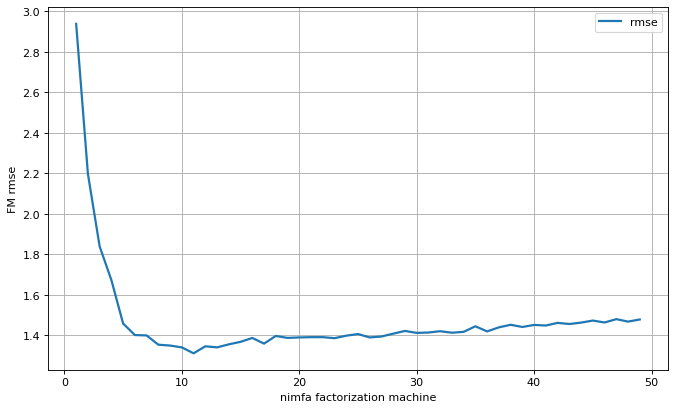

In [25]:
r = NMF_res(m_naned, m_true, np.arange(1,50))

Видим, где находится оптимум. Вывожу rmse для оптимума.

In [26]:
# repeating pipline

m_zeroed = spr.csr_matrix(m_naned.fillna(0).values)
nmf = nimfa.Nmf(m_zeroed, max_iter=200, rank=r, update='euclidean', objective='fro')
nmf_fit = nmf()
A = nmf_fit.basis()
B = nmf_fit.coef()
m_zeroed = np.dot(A.todense(),B.todense())
m_restored = pd.DataFrame(m_zeroed, index = m_true.index, columns = m_true.columns)
print(f'with rank = {r} we have rmse = ', np.sqrt(mse(m_restored, m_true)))

with rank = 11 we have rmse =  1.3233471540656634


Сравнивая с предыдущим результатом, понимаем, что KNN показал себя лучше в данной ситуации.

# Content-based
## Comparison
### TFIDF

Я векторизирую всю текстовую информацию, относящуюся к фильмам. И заполню nan'ы численными значениями ближайших векторов.
Для начала вытащим из датафреймов всю необходимую информацию. К сожалению, значения movieId для датафреймов movies и tags местами не совпадают, поэтому я буду использовать информацию только из датафрейма movies.

In [27]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

def create_dict_tfidf():
    
    '''
    Функция создает словарь, где ключем является Id фильма из m_naned, а значением 
    векторное предстваление ему сопутствующего контента в tfidf
    '''
    
    # movies ids
    Ids = m_naned.columns.to_numpy()
    
    # list of strings that represents content for each movie
    contents = []
    
    for Id in Ids:
    
        # string of content for a single movie 
        content = ''
    
        # add title info
        content += movies[movies.movieId == Id].title.to_numpy()[0].replace("(", " ").replace(")", " ")
    
        # add genre info
        content += movies[movies.movieId == Id].genres.to_numpy()[0].replace("|", " ")
    
        # list of words for movie content
        words = nltk.word_tokenize(content)
        
        # remove bad symbols
        for word in words:
            if not word.isalpha():
                words.remove(word)
        
        # creating sentence from list of this words
        words = ' '.join(words)
        contents += [words]
    
    # tfidf
    vectorizer = TfidfVectorizer()
    tfidf_vectors = vectorizer.fit_transform(contents).todense()
    
    #creating dict where key = id and value = vector
    tfidf_dict = {}
    
    for x in range(len(Ids)):
        tfidf_dict[Ids[x]] = np.array(tfidf_vectors[x])[0]
        
    return tfidf_dict

In [28]:
# vectorizing
tfidf_dict = create_dict_tfidf()

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def restore_by_contnet_based() -> pd.DataFrame:
    
    '''
    Функция возвращает заполненный датафрейм на основе выше озувеченного
    content-based подхода
    '''
    
    # for each column (film)
    for col in m_naned.columns:
        
        # dict of nearest by tfidf other films
        
        dist = {}
        
        for film_id in tfidf_dict.keys():
            
            # distance between these objects
            current_film = np.array([tfidf_dict[col]])
            
            iter_film = np.array([tfidf_dict[film_id]])
            
            dist[film_id] = cosine_similarity(current_film, iter_film)[0][0]
            
        # sort by distance
        dist = dict(sorted(dist.items(), key=lambda dist: dist[1], reverse=True))
            
        # remove current film
        dist.pop(col)
            
        # filling nans in current col
        for film_id in dist.keys():
                
            # id of users that didn't see this film
            user_id = m_naned[col][m_naned[col].isna() == True].index.to_numpy()
            
            # stop when its done
            if len(user_id) == 0:
                break
        
            m_naned[col][user_id] = m_naned[film_id][user_id]
            
    return m_naned

Заполним матрицу и посчитаем rmse:

In [30]:
restored_tfidf = restore_by_contnet_based()
print('tfidf_rmse =', np.sqrt(mse(restored_tfidf, m_true)))

tfidf_rmse = 0.4789342573550597


Как видим, content-based подход не так уж плох. На таком небольшом сэмпле он оказался лучше, чем MatrixFactorization и чуть не дотянул до KNN. Хочу заявить, что согласно этому мини-ресерчу KNN как самый точный, так и самый быстрый алгоритм. Он и будет имплементирован.

# KNN demonstration

In [31]:
from KNNRecommender import KNNRecommender

knnr = KNNRecommender()

knnr.fit(ratings, movies)

# required user_id
knnr.user_predict(407)

['Minority Report (2002)',
 'Fight Club (1999)',
 "Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976)",
 'Lord of the Rings: The Two Towers, The (2002)',
 'Dark Knight, The (2008)',
 'Gone Girl (2014)',
 'Lamerica (1994)',
 'Come and See (Idi i smotri) (1985)',
 'Lesson Faust (1994)',
 'Enter the Void (2009)']

In [32]:
# wrong id
knnr.user_predict(407000)

"user_id = 407000 doesn't exist"